In [59]:
import networkx as nx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
charactersDf = pd.read_csv('characters.csv')
charactersDf.head()

,Unnamed: 0,Name
0,0,Aragorn II Elessar
1,1,Arwen
2,2,Frodo Baggins
3,3,Balin
4,4,Bilbo Baggins


In [8]:
pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
# pattern2 = '\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?\}\}'
gender = '(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)'
race = '(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}'
culture = '(?:Culture=\s)([a-zA-Z]*)(?:<.*?\/>)'


In [7]:
with open("txtfiles/" + charactersDf.Name[0] + '.txt',encoding='utf-8') as f:
    text = f.read()
print(text)

<br />{{Featured star}}
{{Disamb-two|son of Arathorn II|son of Aravir|[[Aragorn I]]}}
{{Disamb-more|Ranger of the North|[[Strider (disambiguation)]]}}
{{Infobox Person Men Dúnedain
| image = Aragorn profile.jpg
| caption = [[Viggo Mortensen]] portrays Aragorn in [[The Lord of the Rings film trilogy]]
| name = 
| othernames = Estel, Thorongil, Elessar (Edhelharn), Telcontar, Envinyatar, Strider, the Dúnadan, Wingfoot
| title = [[Chieftain of the Dúnedain]], [[Heir of Isildur|Heir]] of [[Isildur]]<br />[[King of all the Dúnedain|High]] [[King of the Reunited Kingdom|King]] of the [[Dúnedain]], [[Kings of Arnor|King]] of [[Arnor]], [[Kings of Gondor|King]] of [[Gondor]]
| birth = [[March 1]], [[TA 2931]]
| rule = [[TA 2933]] to [[TA 3019|3019]] (86 years as a Chieftain)<br />[[TA 3019]] to [[FO 120]] (122 years as a King)
| death = [[FO 120]] (aged 210)
| realms = [[Reunited Kingdom]] ([[Arnor]] and [[Gondor]])
| parentage = 
| spouse = [[Arwen|Arwen Undómiel]]
| children = [[Eldarion]] &

In [21]:
def nodeInfo(text):
    genderRe1 = re.findall(r'(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)',text)
    if genderRe1:
        if genderRe1[0] == '':
            gender = 'Unknown'
        else:
            gender = genderRe1[0]
    else:
        gender = 'Unknown'
    raceRe1 = re.findall(r'(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}',text)
    raceRe2 = re.findall(r'(?:race\s?=\s)\[\[(.*?)(?:\|.*?)?\]\]',text)

    if raceRe2:
        race = raceRe2[0] 
    else:
        race = 'none'

    pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
    square = re.findall(pattern1,text)
    edges = square
    return gender,race,edges

g,r,e = nodeInfo(text)


In [22]:
def filterC(chars,charList):
    ret = []
    i = 0
    # print(charList)
    for i in range(len(chars)):
        # print(name, name in charList,type(name))
        if chars[i] in charList:
            ret.append(chars[i])
    return ret
charList = filterC(e,list(charactersDf.Name))
# print(e[11] in list(charactersDf.Name),e[13])
print(len(charList),charList)

53 ['Isildur', 'Arwen', 'Eldarion', 'Isildur', 'Elendil', 'Elrond', 'Arwen', 'Galadriel', 'Gandalf', 'Sauron', 'Bilbo Baggins', 'Sauron', 'Gollum', 'Barliman Butterbur', 'Frodo Baggins', 'Barliman Butterbur', 'Bilbo Baggins', 'Boromir', 'Peregrin Took', 'Meriadoc Brandybuck', 'Samwise Gamgee', 'Legolas', 'Gimli', 'Boromir', 'Saruman', 'Watcher in the Water', "Durin's Bane", 'Galadriel', 'Frodo Baggins', 'Boromir', 'Éomer', 'Théoden', 'Gríma Wormtongue', 'Denethor II', 'Faramir', 'Éowyn', 'Witch-king of Angmar', 'Mouth of Sauron', 'Faramir', 'Galadriel', 'Eldarion', 'Peregrin Took', 'Éomer', 'Théoden', 'Samwise Gamgee', 'Bill Ferny', 'Mouth of Sauron', 'Celeborn', 'Legolas', 'Círdan', 'Lurtz', 'Isildur', 'Eldarion']


In [23]:
def tuples(name, list):
    tmp = []
    for item in list:
        tmp.append((name,item))
    return tmp

In [27]:
nameList = list(charactersDf.Name)
G = nx.DiGraph()

for row in charactersDf.iterrows():
    # try:
    #     name= row[1]['Name']
    #     with open("txtfiles/" + name + '.txt',encoding='utf-8') as f:
    #         text = f.read()
    #     g,r,e = nodeInfo(text)
    #     charList = tuples(filterC(name,e))
    #     G.add_node(name,race = r, gender = g)
    #     # networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    #     G.add_edges_from(charList)
            
    # except:
    #     print('failed',name)

    name= row[1]['Name']
    with open("txtfiles/" + name + '.txt',encoding='utf-8') as f:
        text = f.read()
    g,r,e = nodeInfo(text)
    charList = tuples(name,filterC(e,list(charactersDf.Name)))
    G.add_node(name,race = r, gender = g)
    # networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    G.add_edges_from(charList)
            

    
    


In [53]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 121
Number of edges: 710
Average in degree:   5.8678
Average out degree:   5.8678


In [55]:
#Extracting the giant component
GunD = G.to_undirected()
giant = list(max(nx.connected_components(GunD), key=len))
gcc = G.subgraph(giant).copy()

Text(0.5, 1.0, 'Distribution of toal degrees')

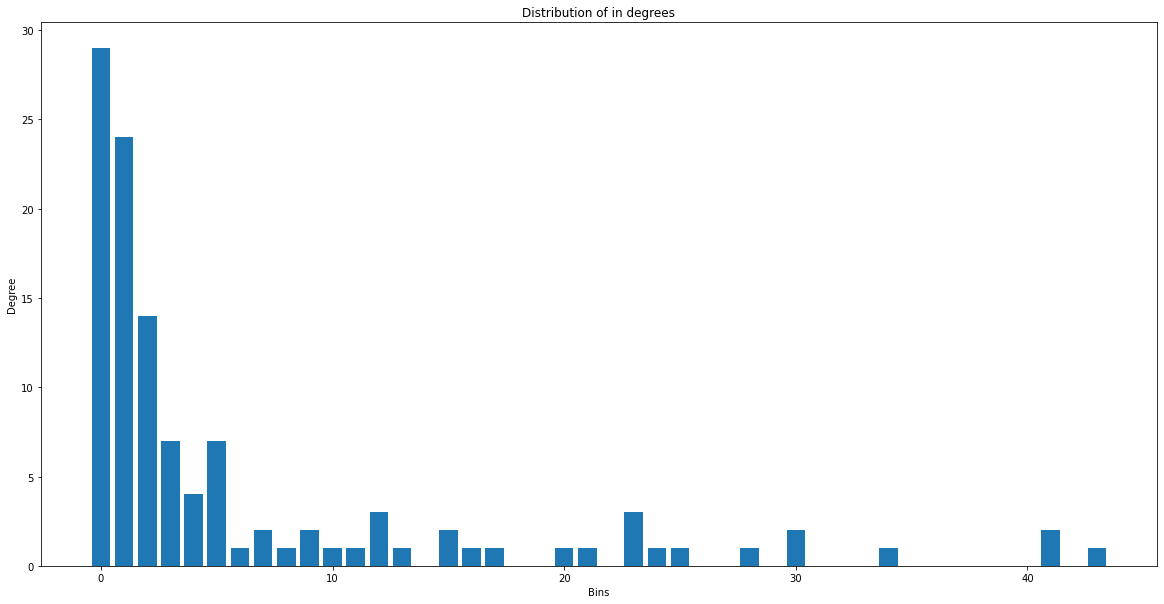

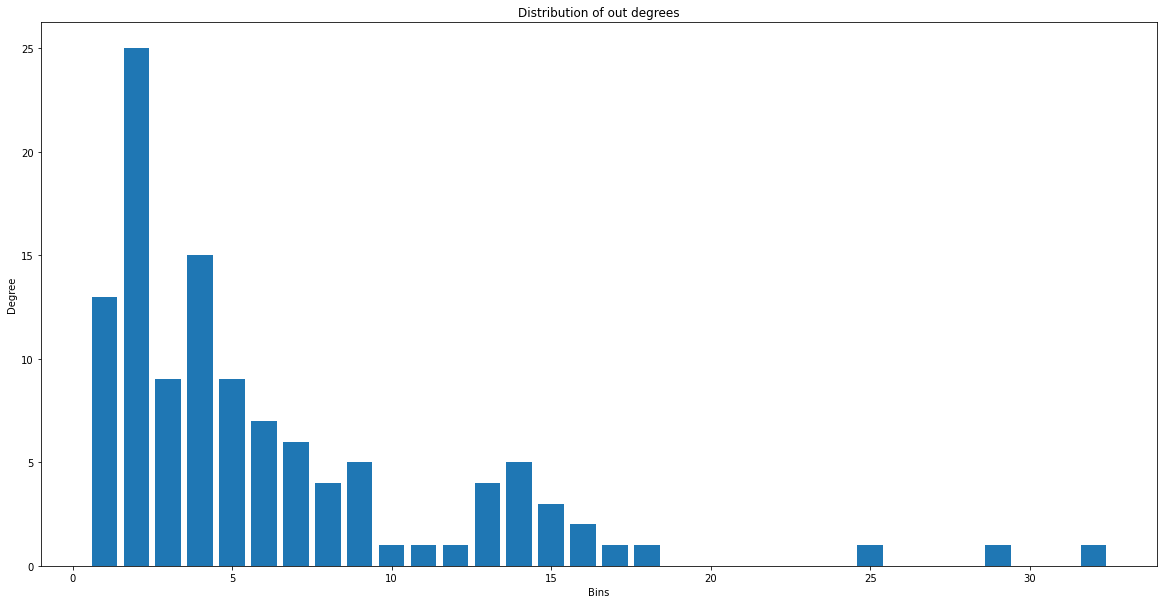

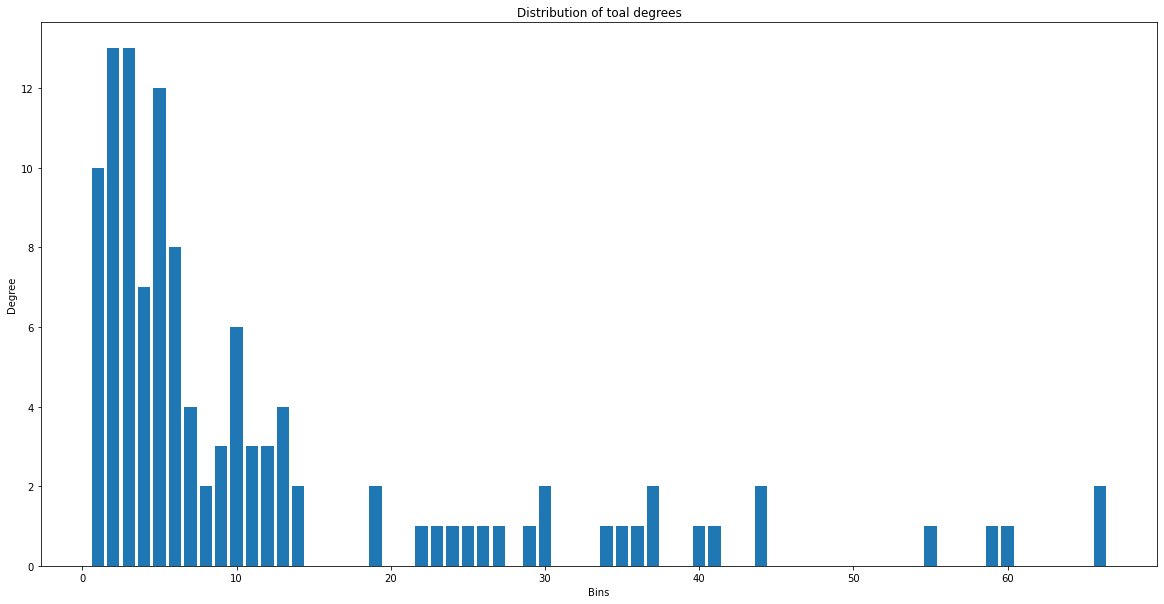

In [60]:
inDegree = [gcc.in_degree(node) for node in gcc.nodes()]
outDegree = [gcc.out_degree(node) for node in gcc.nodes()]
totalDegree = [gcc.degree(node) for node in gcc.nodes()]

maxIn = max(inDegree,key=lambda item:item)
maxOut = max(outDegree,key=lambda item:item)
maxTotal = max(totalDegree,key=lambda item:item)

minIn = min(inDegree,key=lambda item:item)
minOut = min(outDegree,key=lambda item:item)
minTotal = min(totalDegree,key=lambda item:item)

vIn = np.linspace(minIn, maxIn, maxIn-minIn+1)
counts, vIn = np.histogram(inDegree, vIn)
plt.figure(figsize=(20,10))
plt.bar(vIn[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of in degrees')

vOut = np.linspace(minOut, maxOut, maxOut-minOut+1)
counts, vOut = np.histogram(outDegree, vOut)
plt.figure(figsize=(20,10))
plt.bar(vOut[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of out degrees')

vTotal = np.linspace(minTotal, maxTotal, maxTotal-minTotal+1)
counts, vTotal = np.histogram(totalDegree, vTotal)
plt.figure(figsize=(20,10))
plt.bar(vTotal[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of toal degrees')



In [64]:
print(gcc.degree)

[('Aragorn II Elessar', 67), ('Isildur', 19), ('Arwen', 23), ('Eldarion', 10), ('Elendil', 12), ('Elrond', 36), ('Galadriel', 41), ('Gandalf', 59), ('Sauron', 55), ('Bilbo Baggins', 25), ('Gollum', 30), ('Barliman Butterbur', 6), ('Frodo Baggins', 66), ('Boromir', 29), ('Peregrin Took', 44), ('Meriadoc Brandybuck', 44), ('Samwise Gamgee', 34), ('Legolas', 37), ('Gimli', 40), ('Saruman', 60), ('Watcher in the Water', 10), ("Durin's Bane", 8), ('Éomer', 37), ('Théoden', 35), ('Gríma Wormtongue', 19), ('Denethor II', 14), ('Faramir', 30), ('Éowyn', 27), ('Witch-king of Angmar', 26), ('Mouth of Sauron', 10), ('Bill Ferny', 7), ('Celeborn', 22), ('Círdan', 12), ('Lurtz', 4), ('Glóin', 10), ('Farmer Maggot', 5), ('Shelob', 14), ('Gwaihir', 13), ('Rosie Cotton', 10), ('Elanor Gardner', 7), ('Balin', 9), ('Bell Boffin', 3), ('Minto Boffin', 3), ('Filibert Bolger', 2), ('Fredegar Bolger', 6), ('Uglúk', 13), ('Melilot Brandybuck', 1), ('Grishnákh', 11), ('Treebeard', 24), ('Calaglin', 2), ('Gil-